##### Copyright 2022 The TensorFlow Probability Authors

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Adaptive MALT

## Install Dependencies

In [ ]:
!rm -Rf probability
!rm -Rf fun_mc
!rm -Rf inference_gym
!git clone --depth 1 https://github.com/tensorflow/probability.git
!mv probability/spinoffs/fun_mc/fun_mc .
!mv probability/spinoffs/inference_gym/inference_gym .
!mv probability/discussion .
!pip install -U tfp-nightly jax jaxlib immutabledict gin

Cloning into 'probability'...
remote: Enumerating objects: 1486, done.
remote: Counting objects: 100% (1486/1486), done.
remote: Compressing objects: 100% (1276/1276), done.
remote: Total 1486 (delta 373), reused 727 (delta 202), pack-reused 0
Receiving objects: 100% (1486/1486), 39.43 MiB | 12.87 MiB/s, done.
Resolving deltas: 100% (373/373), done.
mv: cannot move 'probability/discussion' to './discussion': Directory not empty
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gin: filename=gin-0.1.6-py3-none-any.whl size=3379 sha256=0b89735dd105e8279d301824687533bb1d34952b9aeec75bdfb35e000a3a1fe3
  Stored in directory: /root/.cache/pip/wheels/5e/a8/6b/f057bdbc4292a581451eaa3c67f5515f2e415111763af159ca
Successfully built gin


# Imports

In [ ]:
import gin
gin.enter_interactive_mode()

import contextlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
from typing import Any
import jax
import jax.numpy as jnp

import tensorflow_probability.substrates.jax as tfp
import tensorflow_probability.substrates.numpy as tfp_np
from inference_gym import using_jax as gym
from discussion.adaptive_malt import adaptive_malt

tfd = tfp.distributions
tfed = tfp.experimental.distributions
tfb = tfp.bijectors

sb.set_style(style='white')

# Utilities

In [ ]:
def randseed(seed=None, do_print=True):
  if seed is None:
    seed = np.random.randint(2**32)
    if do_print:
      print('seed:', seed)
    seed = jax.random.PRNGKey(seed)
  elif isinstance(seed, int):
    seed = jax.random.PRNGKey(seed)
  return seed

# Experiment

In [ ]:
target = gym.targets.VectorModel(gym.targets.RadonContextualEffectsIndiana())

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/backend/jax/ops.py:282: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return arr.astype(dtype)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12573 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/radon/1.0.0.incompleteMLEK7O/radon-train.tfrecord*...:   0%|          | 0/1257…

Dataset radon downloaded and prepared to ~/tensorflow_datasets/radon/1.0.0. Subsequent calls will reuse this data.


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/backend/jax/ops.py:282: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return arr.astype(dtype)


In [ ]:
num_adaptation_steps = 4000

In [ ]:
@jax.jit
def run(seed):

  return adaptive_malt.run_adaptive_mcmc_on_target(
      target=target,
      method='malt',
      num_chains=16,
      init_step_size=1e-2,
      seed=seed,
      num_adaptation_steps=num_adaptation_steps,
      num_results=1000,
  )

In [ ]:
trace, final = run(randseed(0))

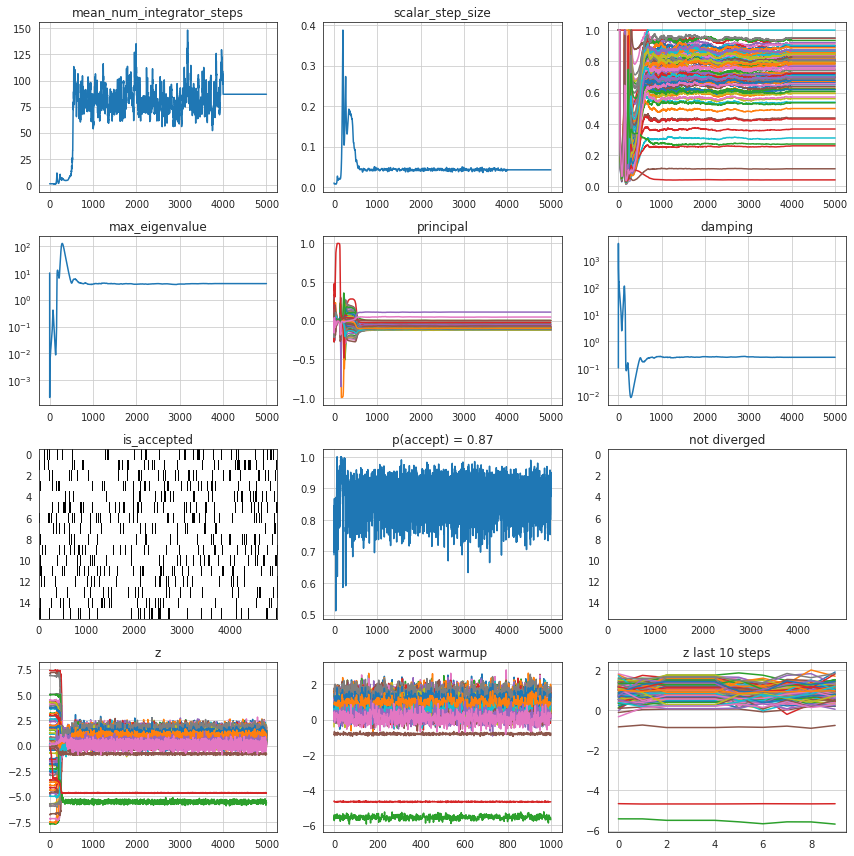

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(12, 12))

ax = axs[0, 0]
ax.set_title('mean_num_integrator_steps')
ax.plot(trace['mean_trajectory_length'] / trace['scalar_step_size'])
ax.grid(True)

ax = axs[0, 1]
ax.set_title('scalar_step_size')
ax.plot(trace['scalar_step_size'])
ax.grid(True)

ax = axs[0, 2]
ax.set_title('vector_step_size')
ax.plot(trace['vector_step_size'])
ax.grid(True)

ax = axs[1, 0]
ax.set_title('max_eigenvalue')
ax.plot(trace['max_eigenvalue'])
ax.set_yscale('log')
ax.grid(True)

ax = axs[1, 1]
ax.set_title('principal')
ax.plot(trace['principal'])
ax.grid(True)

if trace['damping'] is not None:
  ax = axs[1, 2]
  ax.set_title('damping')
  ax.plot(trace['damping'])
  ax.set_yscale('log')
  ax.grid(True)

ax = axs[2, 0]
ax.set_title('is_accepted')
ax.imshow(
    trace['is_accepted'].T,
    cmap='gray',
    interpolation='nearest',
    vmin=0,
    vmax=1)
ax.set_aspect('auto')

ax = axs[2, 1]
p_accept = jnp.exp(jnp.minimum(0., trace['log_accept_ratio'])).mean(-1)
ax.set_title(f'p(accept) = {p_accept.mean():.2f}')
ax.plot(p_accept)
ax.set_aspect('auto')
ax.grid(True)

ax = axs[2, 2]
ax.set_title('not diverged')
ax.imshow(
    (jnp.abs(trace['log_accept_ratio']) < 500.).T,
    cmap='gray',
    interpolation='nearest',
    vmin=0,
    vmax=1)
ax.set_aspect('auto')

ax = axs[3, 0]
ax.set_title('z')
ax.plot(trace['state'][:, 0, :])
ax.grid(True)

ax = axs[3, 1]
ax.set_title('z post warmup')
ax.plot(trace['state'][num_adaptation_steps:, 0, :])
ax.grid(True)

ax = axs[3, 2]
ax.set_title('z last 10 steps')
ax.plot(trace['state'][-10:, 0, :])
ax.grid(True)

fig.tight_layout()

In [ ]:
for name, stats in final['stats'].items():
  print(name)
  print('min ess_per_grad', stats['ess_per_grad'].min())
  print('max rhat', stats['rhat'].max())
  print()

m1
min ess_per_grad 0.0028400226
max rhat 1.0113567

m2
min ess_per_grad 0.0050993804
max rhat 1.0054902

norm_sq
min ess_per_grad 0.0050993804
max rhat 1.0054902

p_m2
min ess_per_grad 0.0051344037
max rhat 1.0034108

